## Imports

In [41]:
#import required libraries
#pandas to make and manipulate dataframes
#numpy for the technical analysis
import pandas as pd
import numpy as np
import math
import yfinance as yf
import tradingview_ta as tv
from tradingview_ta import TA_Handler, Interval, Exchange
import warnings
import hvplot.pandas as hvplot
import mplfinance as mpf
import matplotlib.pyplot as plt
%matplotlib widget
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)


## Input Stock

In [42]:
#With this code you can input any stock and the data for the stock will be pulled from the Yahoo Finance API using yf.Ticker
#The data is pulled for 3 years with a daily timeframe and put into a dataframe called df_stock
value = input("Enter Stock Symbol:")
period = input('enter period of data eg 1y or 2y:')
interval = input('enter candle interval eg 1d, 1wk, 1mo, 1h')
stock = yf.Ticker(value)
print(stock.info)
df_stock = stock.history(period=period, interval=interval)
df_stock.index.duplicated().sum()
df_stock = df_stock.loc[~df_stock.index.duplicated(keep='first')]
df_stock.dropna(inplace=True)
df_stock

Enter Stock Symbol: tsla
enter period of data eg 1y or 2y: 1y
enter candle interval eg 1d, 1wk, 1mo, 1h 1h


{'zip': '78725', 'sector': 'Consumer Cyclical', 'fullTimeEmployees': 99290, 'longBusinessSummary': 'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits. It provides sedans and sport utility vehicles through direct and used vehicle sales, a network of Tesla Superchargers, and in-app upgrades; and purchase financing and leasing services. This segment is also involved in the provision of non-warranty after-sales vehicle services, sale of used vehicles, retail merchandise, and vehicle insurance, as well as sale of products to third party customers; services for electric vehicles through its company-owned service locations, and Tesla mobile service technicians; and vehicle limited warranties a

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2021-07-09 09:30:00-04:00,656.000000,656.690002,644.690002,650.905029,5700063,0,0
2021-07-09 10:30:00-04:00,650.940002,653.539978,648.479980,652.075012,2211296,0,0
2021-07-09 11:30:00-04:00,652.150024,656.690002,650.361389,655.684998,2008134,0,0
2021-07-09 12:30:00-04:00,655.619995,658.909973,653.559998,654.609985,2375168,0,0
2021-07-09 13:30:00-04:00,654.580017,655.399902,652.849976,654.670105,1397758,0,0
...,...,...,...,...,...,...,...
2022-07-08 12:30:00-04:00,749.019592,753.859985,743.390015,753.551880,4130954,0,0
2022-07-08 13:30:00-04:00,753.674988,759.149902,752.202026,757.274780,2702077,0,0
2022-07-08 14:30:00-04:00,757.280029,759.359985,750.929993,751.934998,2658050,0,0
2022-07-08 15:30:00-04:00,752.000000,754.390015,749.179993,752.070007,2591815,0,0


## Creating EMA's for Trade Setup


In [43]:
#Parameter setup (default values in the original indicator)
#These are the constants to be used for the moving averages and future indicator additions
length = 20
mult = 2
length_KC = 21
mult_KC = 2

In [44]:
# Create moving average calculations to add to dataframe. 
m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg = df_stock['Close'].ewm(span=length).mean()
df_stock['Moving average'] = m_avg
# standard deviation
m_std = df_stock['Close'].rolling(window=length).std()


In [45]:
#Create Bollinger Bands for squeeze later
# upper Bollinger Bands
df_stock['upper_BB'] = m_avg + mult * m_std
# lower Bollinger Bands 
df_stock['lower_BB'] = m_avg - mult * m_std
df_stock['bol_percent_b'] = ((df_stock['Close'] - df_stock['lower_BB'])/(df_stock['upper_BB'] - df_stock['lower_BB']))*100

In [46]:
#Stacked Moving averages, exponentially weighted.  Focusing on Fibonacci numbers here with 8, 21, 34, 55 and 89 day moving averages
m_avg_08 = df_stock['Close'].ewm(span=8).mean()
m_avg_13 = df_stock['Close'].ewm(span=13).mean()
m_avg_21 = df_stock['Close'].ewm(span=21).mean()
m_avg_34 = df_stock['Close'].ewm(span=34).mean()
m_avg_55 = df_stock['Close'].ewm(span=55).mean()
m_avg_89 = df_stock['Close'].ewm(span=89).mean()

df_stock['m_avg_08'] = m_avg_08
df_stock['m_avg_13'] = m_avg_13
df_stock['m_avg_21'] = m_avg_21
df_stock['m_avg_34'] = m_avg_34
df_stock['m_avg_55'] = m_avg_55
df_stock['m_avg_89'] = m_avg_89

In [47]:
# calculate Keltner Channel which is a measure of the average true range.  In this case the channels are set to twice the average true range
# first we need to calculate True Range
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma = df_stock['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock['upper_KC'] = m_avg + range_ma * mult_KC
# lower Keltner Channel
df_stock['lower_KC'] = m_avg - range_ma * mult_KC

## Create Candlestick Chart

In [48]:
# Creating dataframe to graph in candle stick mode
ohcl = df_stock[['Open', 'High', 'Close', 'Low', 'Volume']]
display(ohcl.head())
display(ohcl.tail())


,Open,High,Close,Low,Volume
2021-07-09 09:30:00-04:00,656.000000,656.690002,650.905029,644.690002,5700063
2021-07-09 10:30:00-04:00,650.940002,653.539978,652.075012,648.479980,2211296
2021-07-09 11:30:00-04:00,652.150024,656.690002,655.684998,650.361389,2008134
2021-07-09 12:30:00-04:00,655.619995,658.909973,654.609985,653.559998,2375168
2021-07-09 13:30:00-04:00,654.580017,655.399902,654.670105,652.849976,1397758


,Open,High,Close,Low,Volume
2022-07-08 12:30:00-04:00,749.019592,753.859985,753.551880,743.390015,4130954
2022-07-08 13:30:00-04:00,753.674988,759.149902,757.274780,752.202026,2702077
2022-07-08 14:30:00-04:00,757.280029,759.359985,751.934998,750.929993,2658050
2022-07-08 15:30:00-04:00,752.000000,754.390015,752.070007,749.179993,2591815
2022-07-08 16:00:00-04:00,752.289978,752.289978,752.289978,752.289978,0


In [49]:
#Calculating true range and adding to dataframe
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma = df_stock['tr'].ewm(span=length_KC).mean()

In [50]:
#ADX Calculations
# Above 20 ADX means trending and below means sideways movement

plus_dm = df_stock["High"].diff()
minus_dm = df_stock["Low"].diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0

#plus_di and minus di show the direction of the trend, if plus_di > minus_di the trend is positive
#if minus_di > plus_di the trend is negative
df_stock['atr'] = df_stock['tr'].ewm(span=14).mean()
df_stock['plus_di'] = 100 * (plus_dm.ewm(alpha = 1/14).mean() / df_stock['atr'])
df_stock['minus_di'] = abs(100 * (minus_dm.ewm(alpha = 1/14).mean() / df_stock['atr']))
dx = (abs(df_stock['plus_di'] - df_stock['minus_di']) / abs(df_stock['plus_di'] + df_stock['minus_di'])) * 100
adx = ((dx.shift(1) * (14 - 1)) + dx) / 14
df_stock['adx'] = adx.ewm(alpha = 1/14).mean() #ADX>20 is trending ADX<20 not trending
df_stock['ADX_trend'] = 20

## Chart 

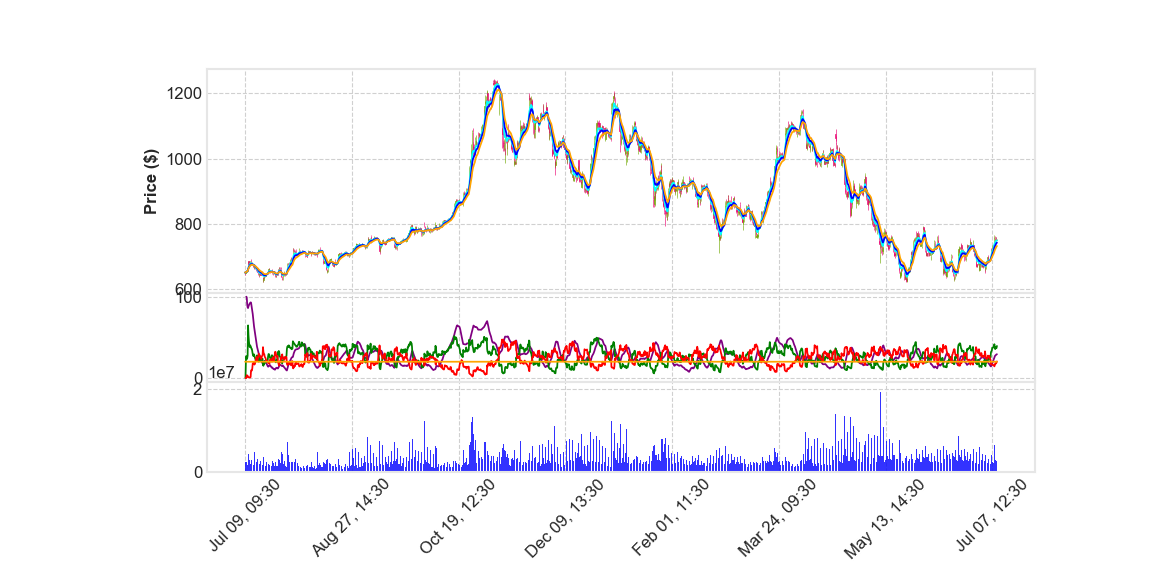

In [51]:
# Adding all the plots including ADX, 
apds = [mpf.make_addplot(df_stock['m_avg_08'], color = 'cyan'),
        mpf.make_addplot(df_stock['m_avg_13'], color = 'blue'),
        mpf.make_addplot(df_stock['m_avg_21'], color = 'orange'),
        mpf.make_addplot(df_stock[['adx']], panel=1, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock[['plus_di']], panel=1, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock[['minus_di']], panel=1, color = 'red', secondary_y=False),
        mpf.make_addplot(df_stock[['ADX_trend']], panel=1, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock['Volume'], panel=2, type='bar', color= 'blue', alpha = 0.8, secondary_y=False)]


fig, axes = mpf.plot(df_stock,
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              ylabel='Price ($)',
              addplot=apds,
              returnfig=True)

#If plus_di (green) > minus_di(orange) then it is a upwards trend. 

## Trade Parameters Checker Functions

In [52]:
def momentum_checker(index):
    if (df_stock['m_avg_08'][index] > df_stock['m_avg_21'][index] > df_stock['m_avg_34'][index] > df_stock['m_avg_55'][index] > df_stock['m_avg_89'][index]):
        print('Positive momentum')
    elif (df_stock['m_avg_08'][index] < df_stock['m_avg_21'][index] < df_stock['m_avg_34'][index] < df_stock['m_avg_55'][index] < df_stock['m_avg_89'][index]):
        print('Negative momentum')
    else:
        print('neutral')

In [53]:
momentum_checker(-1)

Positive momentum


In [54]:
def ADX_trend_flag(index):
    if (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] > df_stock['minus_di'][index]):
        print('positive trend')
    elif (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] < df_stock['minus_di'][index]):
        print('negative trend')
    elif (df_stock['adx'][index] < df_stock['ADX_trend'][index]):
        print('neutral or sideways trend')

In [55]:
ADX_trend_flag(-1)

positive trend


In [56]:
df_stock.dropna()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Moving average,upper_BB,lower_BB,bol_percent_b,m_avg_08,m_avg_13,m_avg_21,m_avg_34,m_avg_55,m_avg_89,tr0,tr1,tr2,tr,upper_KC,lower_KC,atr,plus_di,minus_di,adx,ADX_trend
2021-07-13 14:30:00-04:00,672.710022,673.500000,667.210022,668.070007,1703456,0,0,674.139844,700.368781,647.910907,38.429122,674.846484,674.886942,674.036613,673.026406,672.207397,671.629561,6.289978,0.781189,5.508789,6.289978,689.760372,658.519316,7.696763,27.322766,17.351478,73.110827,20
2021-07-13 15:30:00-04:00,667.989990,669.500000,666.295776,668.909973,1581301,0,0,673.572395,698.139707,649.005083,40.510924,673.520491,673.998183,673.497736,672.694802,671.986892,671.468916,3.204224,1.429993,1.774231,3.204224,688.224613,658.920177,7.066541,27.009087,18.347998,68.163028,20
2021-07-14 09:30:00-04:00,670.750000,676.225525,662.000000,669.200012,5850007,0,0,673.104195,695.955993,650.252397,41.457603,672.556557,673.288851,673.052316,672.419716,671.806159,671.339655,14.225525,7.315552,6.909973,14.225525,689.186537,657.021852,8.063887,29.075841,19.445483,63.528282,20
2021-07-14 10:30:00-04:00,669.450012,678.609924,666.190002,671.169922,4631699,0,0,672.899495,694.382564,651.416425,45.974568,672.247462,672.977153,672.859675,672.323418,671.766067,671.330310,12.419922,9.409912,3.010010,12.419922,689.878062,655.920927,8.667135,27.092855,16.485005,59.520910,20
2021-07-14 11:30:00-04:00,671.030029,672.349976,663.500000,663.858826,2857396,0,0,671.952765,692.115629,651.789901,29.928597,670.378832,671.641500,671.948955,671.683942,671.281032,670.932027,8.849976,1.180054,7.669922,8.849976,689.004323,654.901207,8.692326,24.655804,17.704019,56.285206,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-08 12:30:00-04:00,749.019592,753.859985,743.390015,753.551880,4130954,0,0,723.833381,775.175913,672.490850,78.941404,743.231135,733.813088,722.711292,712.960668,706.542660,703.523587,10.469971,4.590088,5.879883,10.469971,747.576742,700.090021,12.025867,35.492480,17.996368,27.583335,20
2022-07-08 13:30:00-04:00,753.674988,759.149902,752.202026,757.274780,2702077,0,0,727.018276,780.197362,673.839191,78.447748,746.351945,737.164759,725.853428,715.492903,708.354522,704.718058,6.947876,5.598022,1.349854,6.947876,749.866400,704.170153,11.348802,38.252961,17.707880,27.969940,20
2022-07-08 14:30:00-04:00,757.280029,759.359985,750.929993,751.934998,2658050,0,0,729.391298,783.300682,675.481913,70.908883,747.592624,739.274793,728.224479,717.575308,709.910967,705.767323,8.429993,2.085205,6.344788,8.429993,751.695045,707.087550,10.959627,36.918857,17.855960,28.584716,20
2022-07-08 15:30:00-04:00,752.000000,754.390015,749.179993,752.070007,2591815,0,0,731.551175,784.201483,678.900866,69.485957,748.587598,741.102681,730.392255,719.546434,711.416647,706.796272,5.210022,2.455017,2.755005,5.210022,752.774585,710.327764,10.193013,36.860122,19.053882,29.013745,20


## Pickle Dataframe with Indicators

In [57]:
pwd

'C:\\Users\\Jason\\Desktop\\FinalProject'

In [58]:
#df_stock.to_pickle('../Candlestick chart/df_stock.pickle')

In [59]:
#df_stock = pd.read_pickle('../Candlestick chart/df_stock.pickle')
#df_stock.info()

In [60]:
df_stock.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Moving average', 'upper_BB', 'lower_BB', 'bol_percent_b', 'm_avg_08',
       'm_avg_13', 'm_avg_21', 'm_avg_34', 'm_avg_55', 'm_avg_89', 'tr0',
       'tr1', 'tr2', 'tr', 'upper_KC', 'lower_KC', 'atr', 'plus_di',
       'minus_di', 'adx', 'ADX_trend'],
      dtype='object')

## Algo Excecution & Backtest

In [61]:
def implement_ema_strategy(df):
    percent = float(input("Enter percent return"))
    stop_loss = float(input("Enter stop loss percentage"))
        
    buy_price = []
    sell_price = []
    ema_signal = []
    signal = 0.0
    buy_close = 0
    buy = False
  
    
    for row in df.iterrows():
        close = row[1]['Close']
        ema8 = row[1]['m_avg_08']
        ema21 = row[1]['m_avg_21']
        ema13 = row[1]['m_avg_13']
        adx = row[1]['adx']
        adx20 = row[1]['ADX_trend']

        if ema8 > ema13 > ema21 and adx > adx20:
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                ema_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                ema_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                ema_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                ema_signal.append(0)
        elif buy and close <= (buy_close*stop_loss):
            if signal == 1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                ema_signal.append(signal)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            ema_signal.append(0)
        
            
    return buy_price, sell_price, ema_signal

In [65]:
buy_price, sell_price, ema_signal = implement_ema_strategy(df_stock)
df_stock['buy_price'] = buy_price
df_stock['sell_price'] = sell_price
df_stock['ema_signal'] = ema_signal

Enter percent return 1.05
Enter stop loss percentage 1.025


In [94]:
#ema_signal

In [23]:
#buy_price

In [24]:
#sell_price

In [64]:
df_stock.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Moving average', 'upper_BB', 'lower_BB', 'bol_percent_b', 'm_avg_08',
       'm_avg_13', 'm_avg_21', 'm_avg_34', 'm_avg_55', 'm_avg_89', 'tr0',
       'tr1', 'tr2', 'tr', 'upper_KC', 'lower_KC', 'atr', 'plus_di',
       'minus_di', 'adx', 'ADX_trend', 'buy_price', 'sell_price',
       'ema_signal'],
      dtype='object')

In [66]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2021-07-09 09:30:00-04:00 to 2022-07-08 16:00:00-04:00
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            1762 non-null   float64
 1   High            1762 non-null   float64
 2   Low             1762 non-null   float64
 3   Close           1762 non-null   float64
 4   Volume          1762 non-null   int64  
 5   Dividends       1762 non-null   int64  
 6   Stock Splits    1762 non-null   int64  
 7   Moving average  1762 non-null   float64
 8   upper_BB        1743 non-null   float64
 9   lower_BB        1743 non-null   float64
 10  bol_percent_b   1743 non-null   float64
 11  m_avg_08        1762 non-null   float64
 12  m_avg_13        1762 non-null   float64
 13  m_avg_21        1762 non-null   float64
 14  m_avg_34        1762 non-null   float64
 15  m_avg_55        1762 non-null   float64
 16  m_avg_89        1762 non-null 

In [67]:
# This gives the entry and exit signals in the form of a green triangle and red triangle respectively
# Visualize exit position relative to close price
exit = df_stock[df_stock['ema_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock[df_stock['ema_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [index]   (Close)
   .Scatter.Close.I  :Scatter   [index]   (Close)
   .Scatter.Close.II :Scatter   [index]   (Close)

In [30]:
# This code tells us to enter into a position when the squeeze signal is triggered according to the algo function given above
position = []
for i in range(len(ema_signal)):
    if df_stock['ema_signal'][i] < 1:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock['Close'])):
    if df_stock['ema_signal'][i] == 1:
        position[i] = 1
    elif df_stock['ema_signal'][i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = df_stock['Close']
ema_signal = pd.DataFrame(ema_signal).rename(columns = {0:'ema_signal'}).set_index(df_stock.index)
position = pd.DataFrame(position).rename(columns = {0:'ema_position'}).set_index(df_stock.index)

frames = [close_price, ema_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy

,index,Close,ema_signal,ema_position
0,2021-07-09 09:30:00-04:00,650.905029,0.0,0
1,2021-07-09 10:30:00-04:00,652.075012,0.0,0
2,2021-07-09 11:30:00-04:00,655.684998,0.0,0
3,2021-07-09 12:30:00-04:00,654.609985,1.0,1
4,2021-07-09 13:30:00-04:00,654.670105,0.0,1
...,...,...,...,...
1757,2022-07-08 12:30:00-04:00,753.551880,0.0,1
1758,2022-07-08 13:30:00-04:00,757.274780,0.0,1
1759,2022-07-08 14:30:00-04:00,751.934998,0.0,1
1760,2022-07-08 15:30:00-04:00,752.070007,0.0,1


In [31]:
#This code gives us the results of the Algo trade compounding the % return and starting with 100000 as the initial investment and telling 

stock_ret = pd.DataFrame(np.diff(df_stock['Close'])).rename(columns = {0:'returns'})
ema_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['ema_position'][i]
        ema_strategy_ret.append(returns)
    except:
        pass
    
ema_strategy_ret_df = pd.DataFrame(ema_strategy_ret).rename(columns = {0:'ema_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock['Close'][-1])
ema_investment_ret = []

for i in range(len(ema_strategy_ret_df['ema_returns'])):
    returns = (number_of_stocks*ema_strategy_ret_df['ema_returns'][i])
    ema_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock['Close'][i-1])
    
ema_investment_ret_df = pd.DataFrame(ema_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(ema_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the EMA strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the EMA strategy : {profit_percentage}%')
print(return_sum)

Profit gained from the EMA strategy by investing $100k in tsla is 64405.82
Profit percentage of the EMA strategy : 64%
64405.820373535156


## Fibonnacci Level Chart

In [33]:
start_date = input("Enter start date:") 
end_date = input("Enter end date:") 
interval_1 = input("enter candle interval") 
df = stock.history(interval=interval_1,start=start_date,end=end_date)

Enter start date: 2022-01-04
Enter end date: 2022-04-05
enter candle interval 1h


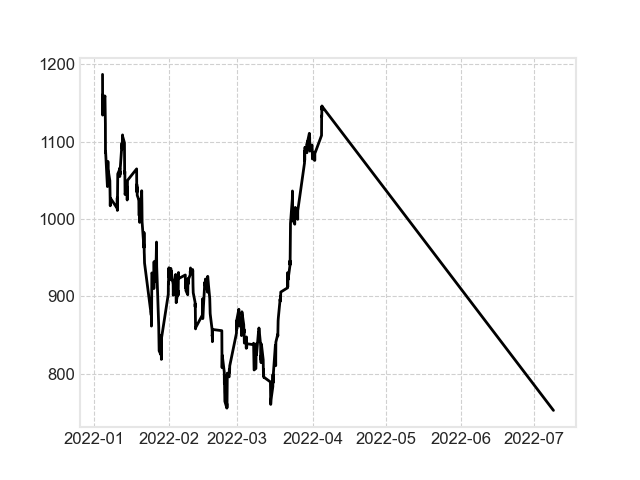

In [34]:
#Graph for the Fibonacci Levels
fig, ax = plt.subplots()
ax.plot(df.Close, color='black')

## Adding Fib Levels

In [35]:
# Define minimum and maximum price points
price_min = df.Close.min()
price_max = df.Close.max()

In [36]:
# Fibonacci Levels using the high and the low of the time period in question
diff = price_max - price_min
level1 = price_max - 0.236 * diff
level2 = price_max - 0.382 * diff
level3 = price_max - 0.500 * diff
level4 = price_max - 0.618 * diff
level5 = price_max - 0.786 * diff

No handles with labels found to put in legend.


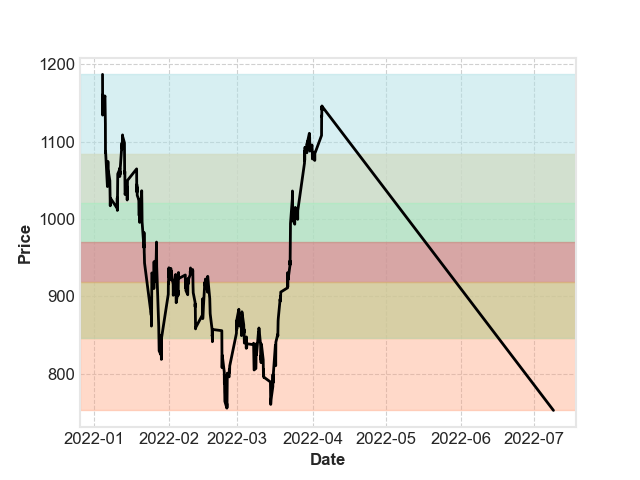

In [37]:
#This adds the Fibonacci Levels to the graph above:
#Level 1 at 23.6%
#Level 2 at 38.2%
#Level 3 at 50%
#Level 4 at 61.8%
ax.axhspan(level1, price_min, alpha=0.4, color='lightsalmon')
ax.axhspan(level2, level1, alpha=0.5, color='palegoldenrod')
ax.axhspan(level3, level2, alpha=0.5, color='palegreen')
ax.axhspan(level4, level3, alpha=0.5, color='red')
ax.axhspan(level5, level4, alpha=0.5, color='orange')
ax.axhspan(price_max, level5, alpha=0.5, color='powderblue')

plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.show()

## Tradingview Rec

In [38]:
symbol_tv = TA_Handler(
    symbol="TSLA",
    screener="america",
    exchange="NASDAQ",
    interval=Interval.INTERVAL_1_HOUR,
    # proxies={'http': 'http://example.com:8080'} # Uncomment to enable proxy (replace the URL).
)
print(symbol_tv.get_analysis().summary)

{'RECOMMENDATION': 'BUY', 'BUY': 14, 'SELL': 3, 'NEUTRAL': 9}
